# Simpsons Classifier


## Images with different sizes: understanding _Spatial Pyramid Pooling_

If the neural network has a fixed size as input images we'll have to deal with it. 

So the possible solutions will be:

* Crop: problem, there is information that gets lost.
* Warp/Resize: problem, the image patterns change and we lose accuracy.
* Padding: problem, the model might be biased to images that contain such a padded border.
* Combination of previous.

Spatial Pyramid Pooling tries to resolve it. Indeed it should improve the efficiency.

Paper: https://arxiv.org/abs/1406.4729

### Obtaining the Dataset

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"XXXX","key":"XXXX"}' > ~/.kaggle/kaggle.json
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

In [0]:
!unzip -qo the-simpsons-characters-dataset.zip -d the-simpsons-characters-dataset
!unzip -qo ./the-simpsons-characters-dataset/simpsons_dataset.zip -d the-simpsons-characters-dataset/
!unzip -qo ./the-simpsons-characters-dataset/kaggle_simpson_testset.zip -d the-simpsons-characters-dataset/

!rm ./the-simpsons-characters-dataset/kaggle_simpson_testset/.DS_Store
!rm ./the-simpsons-characters-dataset/simpsons_dataset/nelson_muntz/.DS_Store

## Defining Datasets

In [3]:
# If running in Google Colab
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
True


In [0]:
#Import libraries
import os
import glob
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize
from random import shuffle
#from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [5]:
#Initial data inside simpsons.tar.gz
info = pd.read_csv('./the-simpsons-characters-dataset/number_pic_char.csv')
print(info)

    Unnamed: 0                      name  total  train  test  bounding_box
0            0             Homer Simpson   2246   1909   337           612
1            1              Ned Flanders   1454   1236   218           595
2            2               Moe Szyslak   1452   1234   218           215
3            3              Lisa Simpson   1354   1151   203           562
4            4              Bart Simpson   1342   1141   201           554
5            5             Marge Simpson   1291   1097   194           557
6            6          Krusty The Clown   1206   1025   181           226
7            7         Principal Skinner   1194   1015   179           506
8            8  Charles Montgomery Burns   1193   1014   179           650
9            9       Milhouse Van Houten   1079    917   162           210
10          10              Chief Wiggum    986    838   148           209
11          11    Abraham Grampa Simpson    913    776   137           595
12          12           

In [0]:
def get_character_directories(path):
    character_directories = os.listdir(path)
    if '.DS_Store' in character_directories: character_directories.remove('.DS_Store')
    return character_directories

def get_images_from_directory(path):
    image_files = os.listdir(path)
    if '.DS_Store' in image_files: image_files.remove('.DS_Store')
    return image_files

In [0]:
#root pats
train_root_path = "./the-simpsons-characters-dataset/simpsons_dataset"
test_root_path = "./the-simpsons-characters-dataset/kaggle_simpson_testset"

#train directories
character_directories = get_character_directories(train_root_path)

In [8]:
def test_paths():
    #configure train dataset
    print("Train: {}".format(character_directories[:5]))

    #images from one train directory
    character_path = train_root_path + "/" + character_directories[1]
    train_image_names = get_images_from_directory(character_path)
    print("Images of {}: {}".format(character_directories[1], train_image_names[:5]))


    #configure test dataset
    test_image_names = get_images_from_directory(test_root_path)
    print("\nTest: {}".format(test_image_names[:5]))

test_paths()

Train: ['barney_gumble', 'kent_brockman', 'milhouse_van_houten', 'abraham_grampa_simpson', 'moe_szyslak']
Images of kent_brockman: ['pic_0082.jpg', 'pic_0371.jpg', 'pic_0247.jpg', 'pic_0038.jpg', 'pic_0262.jpg']

Test: ['marge_simpson_49.jpg', 'marge_simpson_14.jpg', 'nelson_muntz_0.jpg', 'moe_szyslak_5.jpg', 'lisa_simpson_25.jpg']


### Showing Training and Test Samples

In [0]:
def plot_image(image):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Label:milhouse_van_houten, Image:2, Shape:(432, 576, 3)


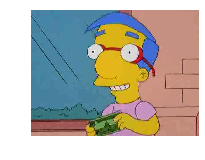

In [10]:
def show_train_image(character_directory, idx):
    directory = os.path.join(train_root_path, character_directory)
    sample_file = get_images_from_directory(directory)[idx]
    path_file = os.path.join(directory, sample_file)
    sample_image = imread(path_file)

    print("Label:{}, Image:{}, Shape:{}".format(character_directory, idx, sample_image.shape))
    plot_image(sample_image)
    
idx = random.randint(0, 10)
show_train_image(character_directories[idx], idx)

Label:moe_szyslak, Image:3, Shape:(171, 114, 3)


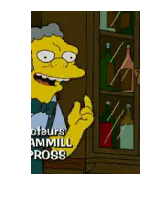

In [11]:
def show_test_image(idx):
    test_image_names = get_images_from_directory(test_root_path)
    sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
    path_file = os.path.join(test_root_path, sample_file)
    sample_image = imread(path_file)

    print("Label:{}, Image:{}, Shape:{}".format('_'.join(sample_name), idx, sample_image.shape))
    plot_image(sample_image)

idx = random.randint(0, 10)
show_test_image(idx)

### Training Images

In [0]:
'''
Input 'different_characters' will define the number of different Simpson
characters the generator is going to return

@Return: tuple (images list, names list)
'''
#Create the batch generator
def batch_generator_training_images(batch_size, different_characters, verbose=False):
    #Obtain the characters Serie with the most number of images
    characters = info.sort_values(by='total', ascending=False).name

    #transform to list with the following format:  Homer Simpson -> homer_simpson
    characters = characters.map(lambda x: x.replace(" ", "_").lower()).tolist()

    path_name_list = list()
    for i in range(0, different_characters):
        directory = os.path.join(train_root_path, characters[i])
        path_name_list += list(map( lambda x: (os.path.join(directory, x), characters[i]), 
                                    get_images_from_directory(directory)))

    #shuffle all the images
    shuffle(path_name_list)
    
    #getting a number of complete chunks according to the batch size
    number_complete_chunks = len(path_name_list)//batch_size
    num_images_in_all_chunks = number_complete_chunks * batch_size
        
    for b in range(0, num_images_in_all_chunks, batch_size):
        if verbose:
            print("init: {}, end:{}".format(b, b+batch_size))
        
        yield (list(map( lambda x: imread(x[0]), path_name_list[b:b + batch_size])), #x == path
               list(map( lambda x: x[1], path_name_list[b:b + batch_size])) ) #x == name


init: 0, end:32
milhouse_van_houten


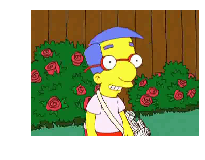

In [13]:
#testing how to show an image from generator
def testing_generator_1():
    for batch in batch_generator_training_images(32, 10, True):
        for img, name in zip(*batch):
            print(name)
            plot_image(img)
            break
        pass
        break
        
testing_generator_1()

In [14]:
#testing the generator
def testing_generator_2():
    group = {}

    for batch in batch_generator_training_images(8, 10, True):
        for img, name in zip(*batch):
            if not img.shape in group:
                group[img.shape] = []
            group[img.shape].append(img)
        pass
        break

    for key, lists in group.items():
        print("shape{} count:{}".format(key, len(lists)))


testing_generator_2()

init: 0, end:8
shape(464, 640, 3) count:1
shape(432, 576, 3) count:2
shape(384, 256, 3) count:1
shape(480, 640, 3) count:1
shape(432, 288, 3) count:1
shape(428, 576, 3) count:1
shape(480, 320, 3) count:1


In [0]:
#global variable
num_classes = 10 #different number of Simpons characters

In [0]:
#one hot encoder
lb = preprocessing.LabelBinarizer()

def customize_onehot_encoder(num_classes=10):
    #Obtain the characters Serie with the most number of images
    characters = info.sort_values(by='total', ascending=False).name

    #transform to list with the following format:  Homer Simpson -> homer_simpson
    names = characters[:num_classes].map(lambda x: x.replace(" ", "_").lower()).tolist()

    print("Character classes: {}\n".format(names))
    lb.fit(names)


### Storing Processed Files On Disk

In [0]:
#global variable
file_prefix = "spp_simpson_train_"
batch_size = 256

In [24]:
def create_processed_files(batch_size=64):
    customize_onehot_encoder(num_classes)
    # Format of data => {shape: {'images':[], 'labels':[]} }
    data = {}
    
    '''
    The batch generator returns a tuple of two lists!!! (list_images, list_names)
    '''
    for cnt, batch in enumerate(batch_generator_training_images(batch_size, num_classes)):
                
        #group by shape
        grouped = {}
        for image, name in zip(*batch):
            if not image.shape in grouped:
                grouped[image.shape] = []
            grouped[image.shape].append((image, name))        
        
        #training images which are grouped by shape at the same time
        for shape, tuple_imagesList_namesList in grouped.items():
            imagesList, namesList = zip(*tuple_imagesList_namesList)
            
            #casting
            images = np.array(imagesList)
            #onehot encoding names
            names = np.array(lb.transform(namesList))
            
            if len(shape) == 3: #just in case dimension are less than 3
                #print("Storing shape:{} with {}".format(shape, len(images)))
                data[shape] = {'images': images, 'labels': names}
            else:
                print("W: Dim image < 3")
        
        #save into disk
        with open("{}{}.pkl".format(file_prefix, cnt), 'wb') as file:
            pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)
            print("{} saved".format("{}{}.pkl".format(file_prefix, cnt)))
        

create_processed_files(batch_size)

Character classes: ['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson', 'bart_simpson', 'marge_simpson', 'krusty_the_clown', 'principal_skinner', 'charles_montgomery_burns', 'milhouse_van_houten']

spp_simpson_train_0.pkl saved
spp_simpson_train_1.pkl saved
spp_simpson_train_2.pkl saved
spp_simpson_train_3.pkl saved
spp_simpson_train_4.pkl saved
spp_simpson_train_5.pkl saved
spp_simpson_train_6.pkl saved
spp_simpson_train_7.pkl saved
spp_simpson_train_8.pkl saved
spp_simpson_train_9.pkl saved
spp_simpson_train_10.pkl saved
spp_simpson_train_11.pkl saved
spp_simpson_train_12.pkl saved
spp_simpson_train_13.pkl saved
spp_simpson_train_14.pkl saved
spp_simpson_train_15.pkl saved
spp_simpson_train_16.pkl saved
spp_simpson_train_17.pkl saved
spp_simpson_train_18.pkl saved
spp_simpson_train_19.pkl saved
spp_simpson_train_20.pkl saved
spp_simpson_train_21.pkl saved
spp_simpson_train_22.pkl saved
spp_simpson_train_23.pkl saved
spp_simpson_train_24.pkl saved
spp_simpson_train_25.pkl 

Since here, the images are processed and stored in different pickle files. 

The format of the __data is a dictionary__ which follows the format:  
```
{shape: {'images':[], 'labels':[]} }
```

## SPP in PyTorch

In [37]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


### Spatial Pyramid Pooling

In [0]:
def spatial_pyramid_pooling(input, levels):
    #s: samples, c: channels, h: height, w: width
    s, c, h, w = input.size()
    #print("{},{},{},{}".format(s,c,h,w))
    pooling_layers = []
    for i in levels:
        kh = h // i
        kw = w //i
        tensor = F.max_pool2d(input, kernel_size=(kh, kw),
                              stride=(kh,kw)).view(s, -1)
        pooling_layers.append(tensor)
        #print("level:{} ksize:({},{}) tensor_size:{}".format(i, kh, kw, tensor.size()))
    return torch.cat(pooling_layers, dim=-1)

### Model

In [0]:
'''
Build a model with a typical network architecture
'''
num_characters = 47
levels = [1,2,4]
output_spp = sum([i**2 for i in levels])

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(output_spp*64, num_characters)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = spatial_pyramid_pooling(x, levels)
        x = self.fc1(x)
        return x

In [0]:
def build_model():
  net = Net()
  
  #move the neural network to the GPU
  if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    net = nn.DataParallel(net)

  return net.to(device)

### Training The Model Using The Processed Files

In [0]:
import os
import pickle
from sklearn.model_selection import train_test_split

def getDatasetsFromPickle(file):
  #print("Processing: {}".format(fname))
  data = pickle.load(file)
  datasets = []
  
  #categorizing according to the shape
  for shape, data in data.items():
    if data['images'].shape[0] < 10:
      #not enough samples to create a validation set
      X_train, y_train = data['images'], data['labels']
      X_val, y_val = X_train.copy(), y_train.copy()
    else:
      X_train, X_val, y_train, y_val = train_test_split(data['images'], data['labels'], test_size=0.2)

    inputs_train, labels_train = torch.FloatTensor(X_train), torch.FloatTensor(y_train)
    inputs_val, labels_val = torch.FloatTensor(X_val), torch.FloatTensor(y_val)

    #permute image as (samples, x, y, channels) to (samples, channels, x, y)
    inputs_train = inputs_train.permute(0, 3, 1, 2)
    inputs_val = inputs_val.permute(0, 3, 1, 2)

    #move the inputs and labels to the GPU and add in datasets
    datasets.append( (inputs_train.to(device), labels_train.to(device), inputs_val.to(device), labels_val.to(device)) )
    
  return datasets

In [0]:
def train_pickle(file, model, stats):
  loss_fn = nn.CrossEntropyLoss() #buit-in softmax, we can use logits directly
  optimizer = optim.Adam(model.parameters())
  
  #retrieve the data
  datasets = getDatasetsFromPickle(file)

  for inputs_train, labels_train, inputs_val, labels_val in datasets:
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs_train)

    #cross entropy loss doesn't accept onehot encoded targets
    #  |-> use the index class instead
    lbls_no_onehot_encoded = torch.argmax(labels_train, dim=1)

    loss = loss_fn(outputs, lbls_no_onehot_encoded)
    loss.backward()
    optimizer.step()

    #statistics
    stats['train_loss'].append(loss.item())
    
    with torch.no_grad():
        outputs = model(inputs_val)
        label_val_classes = torch.argmax(labels_val, dim=1)
        output_classes = torch.argmax(outputs, dim=1)
        stats['val_loss'].append( loss_fn(outputs, label_val_classes).item() )
        stats['acc'].append( (output_classes == label_val_classes).sum().item() / label_val_classes.size(0) )


In [0]:
def train_model(epochs=1):
    customize_onehot_encoder()
    model = build_model()
    stats = {'train_loss':[], 'val_loss':[], 'acc':[]}

    num_files = len(glob.glob("{}*".format(file_prefix)))
    
    for e in range(epochs):
        for i in range(num_files):
            fname = "{}{}.pkl".format(file_prefix, i)
            if os.path.exists(fname):   
                with open(fname, 'rb') as file:
                    train_pickle(file, model, stats)
                    
            #printouts
            if i % 10 == 9:
                printout = "Epoch: {}  Batch: {}  Training loss: {:.3f}  Validation loss: {:.3f}  Accuracy: {:.3f}"
                if len(stats['val_loss'])>0:
                    print(printout.format(e + 1, i + 1, stats['train_loss'][-1], stats['val_loss'][-1], stats['acc'][-1]))

    return model

model1 = train_model()

Character classes: ['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson', 'bart_simpson', 'marge_simpson', 'krusty_the_clown', 'principal_skinner', 'charles_montgomery_burns', 'milhouse_van_houten']



### Testing The Model

Label: lenny_leonard
PREDICTION: homer_simpson


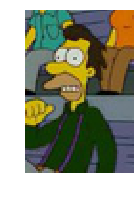

In [281]:
def eyeball_test_model(model):
    idx = random.randint(0, 100)
    test_image_names = get_images_from_directory(test_root_path)
    sample_file, sample_name = test_image_names[idx], test_image_names[idx].split('_')[:-1]
    path_file = os.path.join(test_root_path, sample_file)
    sample_image = imread(path_file)

    print("Label: {}".format('_'.join(sample_name)))
    
    #prediction
    pred = model.predict(sample_image[np.newaxis, :])
    print("PREDICTION: {}".format(lb.inverse_transform(pred)[0]))
 
    #showing the image
    plot_image(sample_image)

eyeball_test_model(model1)